# Making Structural Estimates From Empirical Results

This notebook conducts a quick and dirty structural estimation based on Table 9 of "MPC Heterogeneity and Household Balance Sheets" by Fagereng, Holm, and Natvik <cite data-cite="6202365/SUE56C4B"></cite>, who use Norweigian administrative data on income, household assets, and lottery winnings to examine the MPC from transitory income shocks (lottery prizes).  Their Table 9 reports an estimated MPC broken down by quartiles of bank deposits and
prize size; this table is reproduced here as $\texttt{MPC_target_base}$.  In this demo, we use the Table 9 estimates as targets in a simple structural estimation, seeking to minimize the sum of squared differences between simulated and estimated MPCs by changing the (uniform) distribution of discount factors.  The essential question is how well their results be rationalized by a simple one-asset consumption-saving model.  


The function that estimates discount factors includes several options for estimating different specifications:

1. TypeCount : Integer number of discount factors in discrete distribution; can be set to 1 to turn off _ex ante_ heterogeneity (and to discover that the model has no chance to fit the data well without such heterogeneity).
2. AdjFactor : Scaling factor for the target MPCs; user can try to fit estimated MPCs scaled down by (e.g.) 50%.
3. T_kill    : Maximum number of years the (perpetually young) agents are allowed to live.  Because this is quick and dirty, it's also the number of periods to simulate.
4. Splurge   : Amount of lottery prize that an individual will automatically spend in a moment of excitement (perhaps ancient tradition in Norway requires a big party when you win the lottery), before beginning to behave according to the optimal consumption function.  The patterns in Table 9 can be fit much better when this is set around \$700 --> 0.7.  That doesn't seem like an unreasonable amount of money to spend on a memorable party.
5. do_secant : Boolean indicator for whether to use "secant MPC", which is average MPC over the range of the prize.  MNW believes authors' regressions are estimating this rather than point MPC.  When False, structural estimation uses point MPC after receiving prize.  NB: This is incompatible with Splurge > 0.
6. drop_corner : Boolean for whether to include target MPC in the top left corner, which is greater than 1.  Authors discuss reasons why the MPC from a transitory shock *could* exceed 1.  Option is included here because this target tends to push the estimate around a bit.

In [1]:
# Import python tools

import sys
import os

import numpy as np
from copy import deepcopy

In [2]:
# Import needed tools from HARK

from HARK.utilities import approxUniform, getPercentiles
from HARK.parallel import multiThreadCommands
from HARK.estimation import minimizeNelderMead
from HARK.ConsumptionSaving.ConsIndShockModel import *
from HARK.cstwMPC.SetupParamsCSTW import init_infinite

In [3]:
# Set key problem-specific parameters

TypeCount = 8    # Number of consumer types with heterogeneous discount factors
AdjFactor = 1.0  # Factor by which to scale all of MPCs in Table 9
T_kill = 100     # Don't let agents live past this age
Splurge = 0.7    # Consumers automatically spend this amount of any lottery prize
do_secant = True # If True, calculate MPC by secant, else point MPC
drop_corner = True # If True, ignore upper left corner when calculating distance

In [4]:
# Set standard HARK parameter values

base_params = deepcopy(init_infinite)
base_params['LivPrb'] = [0.975]
base_params['Rfree'] = 1.04/base_params['LivPrb'][0]
base_params['PermShkStd'] = [0.1]
base_params['TranShkStd'] = [0.1]
base_params['T_age'] = T_kill # Kill off agents if they manage to achieve T_kill working years
base_params['AgentCount'] = 10000
base_params['pLvlInitMean'] = np.log(23.72) # From Table 1, in thousands of USD
base_params['T_sim'] = T_kill  # No point simulating past when agents would be killed off

In [5]:
# Define the MPC targets from Fagereng et al Table 9; element i,j is lottery quartile i, deposit quartile j

MPC_target_base = np.array([[1.047, 0.745, 0.720, 0.490],
                            [0.762, 0.640, 0.559, 0.437],
                            [0.663, 0.546, 0.390, 0.386],
                            [0.354, 0.325, 0.242, 0.216]])
MPC_target = AdjFactor*MPC_target_base

In [6]:
# Define the four lottery sizes, in thousands of USD; these are eyeballed centers/averages

lottery_size = np.array([1.625, 3.3741, 7.129, 40.0])

In [7]:
# Make several consumer types to be used during estimation

BaseType = IndShockConsumerType(**base_params)
EstTypeList = []
for j in range(TypeCount):
    EstTypeList.append(deepcopy(BaseType))
    EstTypeList[-1](seed = j)

In [8]:
# Define the objective function

def FagerengObjFunc(center,spread,verbose=False):
    '''
    Objective function for the quick and dirty structural estimation to fit
    Fagereng, Holm, and Natvik's Table 9 results with a basic infinite horizon
    consumption-saving model (with permanent and transitory income shocks).

    Parameters
    ----------
    center : float
        Center of the uniform distribution of discount factors.
    spread : float
        Width of the uniform distribution of discount factors.
    verbose : bool
        When True, print to screen MPC table for these parameters.  When False,
        print (center, spread, distance).

    Returns
    -------
    distance : float
        Euclidean distance between simulated MPCs and (adjusted) Table 9 MPCs.
    '''
    # Give our consumer types the requested discount factor distribution
    beta_set = approxUniform(N=TypeCount,bot=center-spread,top=center+spread)[1]
    for j in range(TypeCount):
        EstTypeList[j](DiscFac = beta_set[j])

    # Solve and simulate all consumer types, then gather their wealth levels
    multiThreadCommands(EstTypeList,['solve()','initializeSim()','simulate(95)','unpackcFunc()'])
    WealthNow = np.concatenate([ThisType.aLvlNow for ThisType in EstTypeList])

    # Get wealth quartile cutoffs and distribute them to each consumer type
    quartile_cuts = getPercentiles(WealthNow,percentiles=[0.25,0.50,0.75])
    for ThisType in EstTypeList:
        WealthQ = np.zeros(ThisType.AgentCount,dtype=int)
        for n in range(3):
            WealthQ[ThisType.aLvlNow > quartile_cuts[n]] += 1
        ThisType(WealthQ = WealthQ)

    # Keep track of MPC sets in lists of lists of arrays
    MPC_set_list = [ [[],[],[],[]],
                     [[],[],[],[]],
                     [[],[],[],[]],
                     [[],[],[],[]] ]

    # Calculate the MPC for each of the four lottery sizes for all agents
    for ThisType in EstTypeList:
        ThisType.simulate(1)
        c_base = ThisType.cNrmNow
        MPC_this_type = np.zeros((ThisType.AgentCount,4))
        for k in range(4): # Get MPC for all agents of this type
            Llvl = lottery_size[k]
            Lnrm = Llvl/ThisType.pLvlNow
            if do_secant:
                SplurgeNrm = Splurge/ThisType.pLvlNow
                mAdj = ThisType.mNrmNow + Lnrm - SplurgeNrm
                cAdj = ThisType.cFunc[0](mAdj) + SplurgeNrm
                MPC_this_type[:,k] = (cAdj - c_base)/Lnrm
            else:
                mAdj = ThisType.mNrmNow + Lnrm
                MPC_this_type[:,k] = cAdj = ThisType.cFunc[0].derivative(mAdj)

        # Sort the MPCs into the proper MPC sets
        for q in range(4):
            these = ThisType.WealthQ == q
            for k in range(4):
                MPC_set_list[k][q].append(MPC_this_type[these,k])

    # Calculate average within each MPC set
    simulated_MPC_means = np.zeros((4,4))
    for k in range(4):
        for q in range(4):
            MPC_array = np.concatenate(MPC_set_list[k][q])
            simulated_MPC_means[k,q] = np.mean(MPC_array)

    # Calculate Euclidean distance between simulated MPC averages and Table 9 targets
    diff = simulated_MPC_means - MPC_target
    if drop_corner:
        diff[0,0] = 0.0
    distance = np.sqrt(np.sum((diff)**2))
    if verbose:
        print(simulated_MPC_means)
    else:
        print (center, spread, distance)
    return distance

In [9]:
# Conduct the estimation

guess = [0.85,0.1]
f_temp = lambda x : FagerengObjFunc(x[0],x[1])
opt_params = minimizeNelderMead(f_temp, guess, verbose=True)
print('Finished estimating for scaling factor of ' + str(AdjFactor) + ' and "splurge amount" of $' + str(1000*Splurge))
print('Optimal (beta,nabla) is ' + str(opt_params) + ', simulated MPCs are:')
dist = FagerengObjFunc(opt_params[0],opt_params[1],True)
print('Distance from Fagereng et al Table 9 is ' + str(dist))

0.85 0.1 0.27883408895212314
0.8925 0.1 0.35390998260541334
0.85 0.10500000000000001 0.26530798881461
0.8075 0.10500000000000001 0.4828691242118494
0.87125 0.10125 0.24781113982995787
0.87125 0.10625000000000001 0.25345270114240204
0.8925 0.10250000000000001 0.36118246270165194
0.860625 0.10437500000000001 0.23718447511093388
0.8606250000000001 0.09937499999999999 0.24045925226231343
0.85 0.10249999999999998 0.2719428828293148
0.8659375 0.1015625 0.23839175723952177
0.8659374999999999 0.1065625 0.24353360989230485
0.8619531250000001 0.101171875 0.23680890871777144
0.856640625 0.10398437500000002 0.24314617851292902
0.86361328125 0.10216796875 0.23668478648914162
0.86494140625 0.09896484374999999 0.23608009325426257
0.8670996093750003 0.09625976562499997 0.23673771218313686
0.8666015624999999 0.09996093749999999 0.23778868289006297
0.863115234375 0.10086914062499999 0.23623538987333287
0.8644433593750002 0.09766601562499999 0.23665686788297197
0.86423583984375 0.09879150390625 0.2363241

### PROBLEM

See what happens if you do not allow a splurge amount at all.  Hint: Think about how this question relates to the `drop_corner` option.

Explain why you get the results you do, and comment on possible interpretations of the "splurge" that might be consistent with economic theory.    
Hint: What the authors are able to measure is actually the marginal propensity to EXPEND, not the marginal propensity to CONSUME as it is defined in our benchmark model.

## Put your solution here

<!-- Results with simulate(100):
1. No splurge drop_corner=False: Gives optimal $\beta=0.7898$ and $\nabla=0.1610$. Simulated MPCs are:
<table style="width:20%">
    <tr>    <td>0.7736</td><td>0.6832</td><td>0.5646</td><td>0.4048</td>  </tr>
    <tr>    <td>0.7435</td><td>0.6648</td><td>0.5530</td><td>0.3963</td>  </tr> 
    <tr>    <td>0.7035</td><td>0.6351</td><td>0.5305</td><td>0.3793</td>  </tr>
    <tr>    <td>0.5613</td><td>0.5043</td><td>0.4126</td><td>0.2926</td>  </tr>
</table>
Distance from Fagereng et al Table 9 is 0.5021.
 -->
<!-- Results with simulate(95): -->
1. No splurge drop_corner=False: Gives optimal $\beta=0.7874$ and $\nabla=0.1602$. Simulated MPCs are:
<table style="width:20%">
    <tr><td>0.7730</td><td>0.6817</td><td>0.5629</td><td>0.4085</td></tr>
    <tr><td>0.7441</td><td>0.6629</td><td>0.5512</td><td>0.4003</td></tr>
    <tr><td>0.7031</td><td>0.6322</td><td>0.5286</td><td>0.3838</td></tr>
    <tr><td>0.5589</td><td>0.5011</td><td>0.4117</td><td>0.2994</td></tr>
</table>
Distance from Fagereng et al Table 9 is 0.4997.
<!-- * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * -->
<!-- Results with simulate(100):
2. No splurge, drop_corner=True: Gives optimal $\beta=0.8144$ and $\nabla=0.1254$. Simulated MPCs are:
<table style="width:20%">
    <tr>    <td>0.6784</td><td>0.6236</td><td>0.5411</td><td>0.4202</td>  </tr> 
    <tr>    <td>0.6590</td><td>0.6097</td><td>0.5304</td><td>0.4116</td>  </tr>
    <tr>    <td>0.6275</td><td>0.5843</td><td>0.5088</td><td>0.3944</td>  </tr>
    <tr>    <td>0.4912</td><td>0.4583</td><td>0.3935</td><td>0.3058</td>  </tr>
</table> 
Distance from Fagereng et al Table 9 is 0.3862.
 -->
<!-- Results with simulate(95): -->
2. No splurge, drop_corner=True: Gives optimal $\beta=0.8111$ and $\nabla=0.1266$. Simulated MPCs are:
<table style="width:20%">
    <tr><td>0.6842</td><td>0.6257</td><td>0.5408</td><td>0.4214</td></tr>
    <tr><td>0.6623</td><td>0.6112</td><td>0.5299</td><td>0.4130</td></tr>
    <tr><td>0.6285</td><td>0.5849</td><td>0.5084</td><td>0.3963</td></tr>
    <tr><td>0.4897</td><td>0.4584</td><td>0.3944</td><td>0.3105</td></tr>
</table> 
Distance from Fagereng et al Table 9 is 0.3853.
<!-- * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * -->
<!-- Results with simulate(100):
3. Splurge=0.7, drop_corner=False: Gives optimal $\beta=0.8572$ and $\nabla=0.1163$. Simulated MPCs are:
<table style="width:25%">
    <tr>    <td>0.7813</td><td>0.7490</td><td>0.6977</td><td>0.5700</td>  </tr>
    <tr>    <td>0.6817</td><td>0.6409</td><td>0.5710</td><td>0.3973</td>  </tr>
    <tr>    <td>0.6100</td><td>0.5703</td><td>0.4933</td><td>0.3049</td>  </tr>
    <tr>    <td>0.4383</td><td>0.4106</td><td>0.3440</td><td>0.1940</td>  </tr>
</table> 
Distance from Fagereng et al Table 9 is 0.3629.
-->
<!-- Results with simulate(95): -->
3. Splurge=0.7, drop_corner=False: Gives optimal $\beta=0.8532$ and $\nabla=0.1138$. Simulated MPCs are:
<table style="width:25%">
    <tr><td>0.7809</td><td>0.7503</td><td>0.6993</td><td>0.5808</td></tr>
    <tr><td>0.6799</td><td>0.6424</td><td>0.5735</td><td>0.4120</td></tr>
    <tr><td>0.6062</td><td>0.5713</td><td>0.4964</td><td>0.3220</td></tr>
    <tr><td>0.4329</td><td>0.4106</td><td>0.3481</td><td>0.2128</td></tr>
</table>        
Distance from Fagereng et al Table 9 is 0.3622.
<!-- * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * -->
<!-- Results with simulate(100):
4. Splurge=0.7, drop_corner=True: Gives optimal $\beta=0.8683$ and $\nabla=0.0983$. Simulated MPCs are:
<table style="width:25%">
    <tr>    <td>0.7615</td><td>0.7330</td><td>0.6888</td><td>0.5805</td>  </tr>
    <tr>    <td>0.6541</td><td>0.6189</td><td>0.5587</td><td>0.4108</td>  </tr>
    <tr>    <td>0.5785</td><td>0.5455</td><td>0.4795</td><td>0.3197</td>  </tr>
    <tr>    <td>0.4038</td><td>0.3842</td><td>0.3312</td><td>0.2061</td>  </tr>
</table>
Distance from Fagereng et al Table 9 is 0.2359.
-->
<!-- Results with simulate(95): -->
4. Splurge=0.7, drop_corner=True: Gives optimal $\beta=0.8642$ and $\nabla=0.0997$. Simulated MPCs are:
<table style="width:25%">
    <tr>  <td>0.7632</td><td>0.7352</td><td>0.6895</td><td>0.5824</td></tr>
    <tr>  <td>0.6554</td><td>0.6218</td><td>0.5599</td><td>0.4144</td></tr>
    <tr>  <td>0.5780</td><td>0.5481</td><td>0.4812</td><td>0.3247</td></tr>
    <tr>  <td>0.4023</td><td>0.3865</td><td>0.3343</td><td>0.2152</td></tr>
</table>
Distance from Fagereng et al Table 9 is 0.2360.

## Discussion

The first thing to note about these results is the large drop in the distance from Table 9 in Fagereng et al when setting drop_corner=True (compare results 1 vs 2 and results 3 vs 4). In the table the MPC for the lowest lottery size and lowest wealth quartile is 1.047. Even with splurge=0.7 the model cannot generate an MPC close to (and certainly not above) 1. The deviation between the model MPC and the value in the data will therefore be considerable, contributing to a larger distance. Given that the model cannot generate an MPC > 1, it makes sense to drop that value, but the improvement in the distance is to some extent mechanical. Ignoring that value yields higher estimates of $\beta$ however, since lowering $\beta$ is the model's best attempt at increasing the MPC. 

Focusing rather on the splurge component, we compare results 2 (without a splurge) vs 4 (with a splurge included). Setting splurge=0.7 gives an automatic increase in spending after the lottery which is not generated by the model. In the real world such an increase in spending makes sense if, for example, the lottery win enables a purchase of a durable good that a consumer was saving for. Such a mechanism is not included in the model. 

With the splurge fixed and independent of wealth and lottery sizes, the inclusion of the splurge increases MPCs for the smallest lottery wins and reduces it for the larger wins. This enables the model to generate a larger difference in MPCs for different lottery sizes, and improves the fit with the data. The improved fit is achieved with $\beta$ centered around $0.86$ rather than $0.81$ since the splurge enables the model to imply high MPCs for the smallest lottery wins without needing to reduce $\beta$. The higher $\beta$ then enables lower MPCs for the larger lottery wins. 


### PROBLEM

Call the _Marginal Propensity to Continue Consuming_ (MPCC) in year `t+n` the proportion of lottery winnings that get spent in year `t+n`.  That is, if consumption is higher in year `t+2` by an amount corresponding to 14 percent of lottery winnings, we would say  _the MPCC in t+2 is 14 percent.

For the baseline version of the model with the "splurge" component, calculate the MPCC's for years `t+1` through `t+3` and plot them together with the MPC in the first year (including the splurge component)


In [10]:
# Put your solution here

# Use estimated beta range from case 4 above (splurge + drop_corner=True)
center = opt_params[0]
spread = opt_params[1]

# Give our consumer types the estimated discount factor distribution
beta_set = approxUniform(N=TypeCount,bot=center-spread,top=center+spread)[1]
for j in range(TypeCount):
    EstTypeList[j](DiscFac = beta_set[j])
    #EstTypeList[j].track_vars = ['mNrmNow', 'cNrmNow', 'pLvlNow']

# Solve and simulate all consumer types, then gather their wealth levels
multiThreadCommands(EstTypeList,['solve()','initializeSim()','simulate(95)','unpackcFunc()'])
WealthNow = np.concatenate([ThisType.aLvlNow for ThisType in EstTypeList])

# Get wealth quartile cutoffs and distribute them to each consumer type
quartile_cuts = getPercentiles(WealthNow,percentiles=[0.25,0.50,0.75])
for ThisType in EstTypeList:
    WealthQ = np.zeros(ThisType.AgentCount,dtype=int)
    for n in range(3):
        WealthQ[ThisType.aLvlNow > quartile_cuts[n]] += 1
    ThisType(WealthQ = WealthQ)

print('Done assigning wealth quartiles')

Done assigning wealth quartiles


In [19]:
# Now for each type we want to simulate 4 periods and calculate MPCCs 
# from consumptions with and without lottery winnings
numPeriods = 4

simulated_MPC_means = np.zeros((4,4,numPeriods))    # 3d array to store MPC matrices for t to t+n

# Need a structure to keep track of how wealth evolves after the lottery win
lotteryWealthMat = np.zeros((base_params['AgentCount'],4,numPeriods))
lotteryWealthList = []
for j in range(TypeCount):
    lotteryWealthList.append(deepcopy(lotteryWealthMat))

for n in range(numPeriods):
    # Keep track of MPC sets in lists of lists of arrays
    MPC_set_list = [ [[],[],[],[]],
                     [[],[],[],[]],
                     [[],[],[],[]],
                     [[],[],[],[]] ]

    for ThisType in EstTypeList:
        ThisType.simulate(1)
        c_base = ThisType.cNrmNow
        MPC_this_type = np.zeros((ThisType.AgentCount,4))
        for k in range(4): 
            if n == 0: # Calculate the initial period MPCs 
                Llvl = lottery_size[k]*0
                Lnrm = Llvl/ThisType.pLvlNow
                SplurgeNrm = Splurge/ThisType.pLvlNow
                mAdj = ThisType.mNrmNow + Lnrm - SplurgeNrm
                cAdj = ThisType.cFunc[0](mAdj) + SplurgeNrm
                MPC_this_type[:,k] = (cAdj - c_base)#/Lnrm
                # Store the resulting wealth after the lottery win
                lotteryWealthList[ThisType.seed][:,k,n] = ThisType.mNrmNow + Lnrm - cAdj
            else:      # Calculate MPCC after initial lottery win
                       # by iterating last period's lottery wealth one period forward
                Llvl = lottery_size[k]*0
                Lnrm = Llvl/ThisType.pLvlNow
                mAdjPrev = lotteryWealthList[ThisType.seed][:,k,n-1]
                mAdjNew = mAdjPrev*base_params['Rfree']/ThisType.PermShkNow + ThisType.TranShkNow
                cAdj = ThisType.cFunc[0](mAdjNew)
                MPC_this_type[:,k] = (cAdj - c_base)#/Lnrm            
                lotteryWealthList[ThisType.seed][:,k,n] = mAdjNew-cAdj
                
        # Sort the MPCs into the proper MPC sets
        for q in range(4):
            these = ThisType.WealthQ == q
            for k in range(4):
                MPC_set_list[k][q].append(MPC_this_type[these,k])

    # Calculate average within each MPC set
    for k in range(4):
        for q in range(4):
            MPC_array = np.concatenate(MPC_set_list[k][q])
            simulated_MPC_means[k,q, n] = np.mean(MPC_array)

In [20]:
print(np.round(simulated_MPC_means[:,:,0],4))
print(np.round(simulated_MPC_means[:,:,1],4))
print(np.round(simulated_MPC_means[:,:,2],4))
print(np.round(simulated_MPC_means[:,:,3],4))


[[   nan 0.019  0.0195 0.0244]
 [   nan 0.019  0.0195 0.0244]
 [   nan 0.019  0.0195 0.0244]
 [   nan 0.019  0.0195 0.0244]]
[[    nan -0.0072 -0.0043 -0.    ]
 [    nan -0.0072 -0.0043 -0.    ]
 [    nan -0.0072 -0.0043 -0.    ]
 [    nan -0.0072 -0.0043 -0.    ]]
[[    nan -0.0007  0.0012  0.0063]
 [    nan -0.0007  0.0012  0.0063]
 [    nan -0.0007  0.0012  0.0063]
 [    nan -0.0007  0.0012  0.0063]]
[[   nan 0.0025 0.0042 0.01  ]
 [   nan 0.0025 0.0042 0.01  ]
 [   nan 0.0025 0.0042 0.01  ]
 [   nan 0.0025 0.0042 0.01  ]]


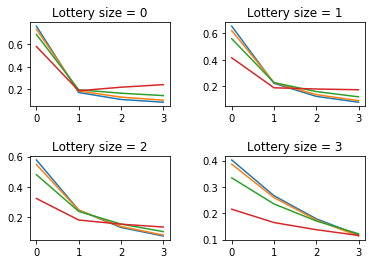

In [13]:
import matplotlib.pyplot as plt

for lottSize in range(4):
    plt.subplot(2,2,lottSize+1)
    for q in range(4):
        labStr = "Wealth Q=" + str(q)
        plt.plot(simulated_MPC_means[lottSize,q,:], label=labStr)
        plt.xticks(ticks=range(4))
    plt.title('Lottery size = %d' %lottSize)
plt.subplots_adjust(hspace=0.6, wspace=0.4)
# plt.legend(loc='best')
plt.show()